## Import libraries

In [1]:
import numpy as np
import pandas as pd
from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

## Read data

In [2]:
label_table = pd.read_csv('data/label_table.csv')
del label_table['Unnamed: 0']
label_table

,label,polymer
0,0,Acrylic
1,1,Acrylonitrile Butadiene Styrene
2,2,Cotton
3,3,Polyamide
4,4,Polycarbonate
5,5,Polyethylene
6,6,Polyethylene Terephthalate
7,7,Polyethylene Vinyl Acetate
8,8,Polylactic acid
9,9,Polypropylene


In [3]:
# Read reference library
reference_library = pd.read_csv('data/reference_library.csv')
del reference_library['Unnamed: 0']
reference_library = reference_library.merge(label_table)
reference_library = reference_library.iloc[:,[0,1,-1]+list(np.arange(2,reference_library.shape[1]-1))]
wl_list = np.float64(reference_library.columns[3:])
reference_library.head()

,id,polymer,label,674.9918,676.9203,678.8489,680.7775,682.706,684.6345,686.5631,...,3982.452,3984.38,3986.309,3988.237,3990.166,3992.094,3994.023,3995.951,3997.88,3999.809
0,ABS 1. Orange LEGO Fragment.CSV,Acrylonitrile Butadiene Styrene,1,-2.558419,-2.617344,-2.647565,-2.732447,-2.850790,-2.988317,-3.196264,...,0.637547,0.634108,0.648501,0.656325,0.655386,0.664971,0.665558,0.651044,0.645997,0.654486
1,ABS 10. Brown LEGO Fragment.CSV,Acrylonitrile Butadiene Styrene,1,-2.265023,-2.309608,-2.374530,-2.446580,-2.540923,-2.695691,-2.891053,...,0.832796,0.829453,0.840934,0.849702,0.846336,0.842218,0.841419,0.842121,0.844761,0.844858
2,ABS 11. Black LEGO Fragment.CSV,Acrylonitrile Butadiene Styrene,1,-2.061761,-2.108204,-2.142853,-2.220130,-2.299527,-2.437295,-2.648397,...,0.696705,0.688823,0.696865,0.706376,0.712737,0.715482,0.715432,0.705735,0.699177,0.700378
3,ABS 12. White LEGO Fragment.CSV,Acrylonitrile Butadiene Styrene,1,-4.333531,-4.334141,-4.328848,-4.340096,-4.405816,-4.480118,-4.589519,...,0.439976,0.435928,0.447634,0.458499,0.456927,0.451888,0.451876,0.449256,0.447064,0.447839
4,ABS 14. White Fridge Lining Fragment.CSV,Acrylonitrile Butadiene Styrene,1,-3.435755,-3.467888,-3.454651,-3.491705,-3.640182,-3.822259,-4.020453,...,0.419135,0.400617,0.409493,0.422987,0.430602,0.433362,0.434856,0.427894,0.423303,0.421881


In [4]:
# Read calibration set
calibration_set = pd.read_csv('data/calibration_set.csv')
del calibration_set['Unnamed: 0']
calibration_set = calibration_set.merge(label_table)
calibration_set = calibration_set.iloc[:,[0,1,-1]+list(np.arange(2,calibration_set.shape[1]-1))]
calibration_set.head()

,id,polymer,label,674.9918,676.9203,678.8489,680.7775,682.706,684.6345,686.5631,...,3982.452,3984.38,3986.309,3988.237,3990.166,3992.094,3994.023,3995.951,3997.88,3999.809
0,ABS 1. Black Fragment.CSV,Acrylonitrile Butadiene Styrene,1,-1.652339,-1.716827,-1.864428,-1.967062,-2.049846,-2.187845,-2.477509,...,0.478590,0.474398,0.473947,0.481465,0.479542,0.479669,0.483015,0.476869,0.475167,0.482083
1,C1. Black Fiber.CSV,Cotton,2,-2.078704,-1.982948,-2.029716,-2.095964,-2.034606,-1.984105,-1.996106,...,0.645537,0.647716,0.635339,0.639721,0.645783,0.651506,0.658292,0.651568,0.639082,0.646376
2,C11. Pink Fiber.CSV,Cotton,2,-1.892132,-2.015299,-1.961850,-1.451541,-1.313717,-1.601891,-1.780813,...,0.574859,0.604480,0.671450,0.648548,0.610894,0.618868,0.656689,0.661730,0.637612,0.655541
3,C12. Orange Fiber.CSV,Cotton,2,-2.446316,-2.150587,-1.492802,-1.667398,-2.192545,-2.162706,-2.082015,...,0.715497,0.733312,0.733961,0.698604,0.746962,0.768639,0.707907,0.671263,0.710268,0.733393
4,C2. Blue Fiber.CSV,Cotton,2,-1.603700,-1.384547,-1.250493,-1.339149,-1.630421,-1.672313,-1.584448,...,0.793405,0.784863,0.782943,0.764801,0.776791,0.812696,0.838113,0.822244,0.789669,0.810737


In [5]:
# Read test set
test_set = pd.read_csv('data/test_set.csv')
del test_set['Unnamed: 0']
#del test_set['polymer']
if 'polymer' in test_set.columns:
    test_set['polymer'] = np.object_(test_set['polymer'])
    test_set = test_set.merge(label_table, on='polymer', how='left')
    test_set = test_set.iloc[:,[0,1,-1]+list(np.arange(2,test_set.shape[1]-1))]
test_set.head()

,id,polymer,label,674.9918,676.9203,678.8489,680.7775,682.706,684.6345,686.5631,...,3982.452,3984.38,3986.309,3988.237,3990.166,3992.094,3994.023,3995.951,3997.88,3999.809
0,C10. Grey Fiber.CSV,Cotton,2,-1.718001,-1.774414,-1.845041,-1.777577,-1.613186,-1.534224,-1.666716,...,0.764932,0.759899,0.778513,0.771272,0.740598,0.742840,0.761591,0.772663,0.782524,0.780806
1,C7. Blue Fiber.CSV,Cotton,2,-2.336862,-2.031571,-1.748581,-1.779784,-1.854608,-1.764007,-1.812488,...,0.604466,0.614779,0.629737,0.637034,0.624619,0.616364,0.622252,0.610927,0.599370,0.602518
2,C8. Pink Fiber Bundle.CSV,Cotton,2,-2.332254,-2.183670,-2.115925,-2.128278,-2.073333,-1.934244,-1.909948,...,0.590041,0.599690,0.612782,0.606586,0.603848,0.608498,0.610127,0.610592,0.608082,0.609764
3,EVA 3. Grey Foam.CSV,Polyethylene Vinyl Acetate,7,-1.988912,-1.892084,-1.856486,-1.828531,-1.843740,-1.851624,-1.853919,...,0.746995,0.743570,0.742325,0.742323,0.739810,0.735186,0.737089,0.742308,0.744095,0.739267
4,PA 1. Green Film.CSV,Polyamide,3,-4.099690,-4.047610,-4.049106,-4.005303,-3.984499,-3.946866,-3.942559,...,0.919416,0.917194,0.921602,0.928591,0.929884,0.924964,0.923410,0.927008,0.927717,0.925534


## Process spectral data

In [6]:
calibration_set, test_set = hom_data(reference_library, calibration_set, test_set)

In [7]:
# store labels/polymer for reference library
y_train = reference_library.iloc[:,1].to_numpy()
label_train = reference_library.iloc[:,2].to_numpy()
# store spectra for reference library
X_train = reference_library.iloc[:,3:].to_numpy()

# Perform SNV normalization
X_train = (X_train - X_train.mean(1)[:, None]) / X_train.std(1)[:, None]

# store labels/polymer for calibration set
y_cal = calibration_set.iloc[:,1].to_numpy()
label_cal = calibration_set.iloc[:,2].to_numpy()
# store spectra for calibration set
X_cal = calibration_set.iloc[:,3:].to_numpy()

# Perform SNV normalization
X_cal = (X_cal - X_cal.mean(1)[:, None]) / X_cal.std(1)[:, None]


# store labels/polymer for test set
y_test = test_set.iloc[:,1].to_numpy()
label_test = test_set.iloc[:,2].to_numpy()
# store spectra for calibration set
X_test = test_set.iloc[:,3:].to_numpy()

# Perform SNV normalization
X_test = (X_test - X_test.mean(1)[:, None]) / X_test.std(1)[:, None]

Polyethylene Vinyl Acetate


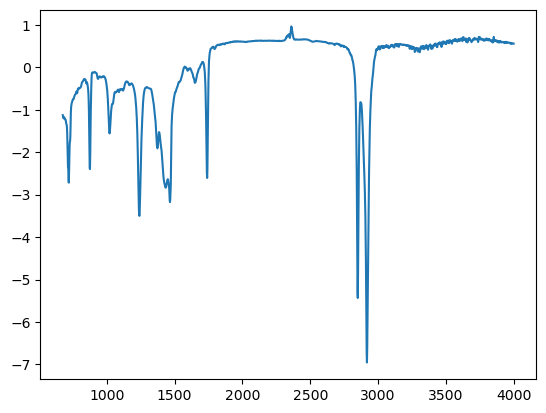

In [8]:
print(y_train[40])
_ = plt.plot(wl_list, X_train[40,:])

## Calculate HQI

In [9]:
# Nearest Neighbor

# Calculate HQI for calibration set
smx_cal = smx_nn(X_train, X_cal, label_train)

# Calculate HQI for test set
smx_test = smx_nn(X_train, X_test, label_train)

## Perform Conformal Prediction over the test set

In [10]:
# Set confidence level 1 - alpha
n = smx_cal.shape[0]
alpha = 0.1
prediction_sets, qhat = conform_pred(smx_cal, smx_test, label_cal, n, alpha, cond=0)

# If we know to true labels of the test set, calculate the empirical confidence 
if label_test[0] != '' and not np.isnan(label_test[0]):
    empirical_confidence = prediction_sets[np.arange(label_test.shape[0]),label_test].mean()
else:
    empirical_confidence = None

In [11]:
print('Threshold(s) used: '+str(np.int64(100*(1-qhat))/100))
if empirical_confidence is not None:
    print('Empirical confidence: '+str(int(100*empirical_confidence)/100))
print('Mean prediction set size: '+str(np.round(prediction_sets.sum(1).mean(), 2)))

Threshold(s) used: 0.88
Empirical confidence: 0.94
Mean prediction set size: 1.82


In [12]:
prediction_sets_n = [list(label_table.loc[ps,'polymer']) for ps in prediction_sets]
prediction_sets_size = np.array([len(ps) for ps in prediction_sets_n])

In [13]:
zero_label = np.where(prediction_sets_size == 0)[0]
single_label = np.where(prediction_sets_size == 1)[0]
mult_label = np.where(prediction_sets_size > 1)[0]

print('Sets with zero labels: ' + str(zero_label.shape[0]))
print('Sets with one label: ' + str(single_label.shape[0]))
print('Sets with >1 labels: ' + str(mult_label.shape[0]))

Sets with zero labels: 0
Sets with one label: 27
Sets with >1 labels: 11


In [14]:
if y_test[0] != '' and not np.isnan(label_test[0]):
    print('accuracy of single labels: ' +str(np.mean([prediction_sets_n[i][0]==y_test[i] for i in single_label])))

accuracy of single labels: 1.0


In [27]:
prediction_sets_n

[['Cotton'],
 ['Cotton'],
 ['Cotton'],
 ['Acrylonitrile Butadiene Styrene',
  'Cotton',
  'Polyethylene',
  'Polyethylene Vinyl Acetate',
  'Polyvinyl Chloride',
  'Rubber'],
 ['Polyamide', 'Polystyrene'],
 ['Polyamide'],
 ['Polyamide'],
 ['Polyethylene', 'Polyethylene Vinyl Acetate'],
 ['Polyethylene'],
 ['Polyethylene'],
 ['Polyethylene'],
 ['Polyethylene'],
 ['Polyethylene'],
 ['Polyethylene'],
 ['Polyethylene', 'Polyethylene Vinyl Acetate'],
 ['Polyethylene', 'Polyethylene Vinyl Acetate'],
 ['Polyethylene Terephthalate'],
 ['Polyethylene Terephthalate'],
 ['Polypropylene'],
 ['Polypropylene'],
 ['Polypropylene', 'Rubber'],
 ['Polypropylene'],
 ['Polypropylene'],
 ['Polypropylene'],
 ['Cotton',
  'Polyamide',
  'Polyethylene Terephthalate',
  'Polyethylene Vinyl Acetate',
  'Polypropylene',
  'Polystyrene',
  'Polyurethane',
  'Polyvinyl Chloride',
  'Rubber'],
 ['Polypropylene'],
 ['Polypropylene'],
 ['Polypropylene'],
 ['Acrylonitrile Butadiene Styrene',
  'Cotton',
  'Polystyrene

In [30]:
output = [prediction_sets_n[i][0] if i in single_label else 
          '--outlier--' if i in zero_label else 
          '--manual check!--' for i in range(label_test.shape[0])]
output_df = pd.DataFrame({'id':test_set['id'],
                          'prection_set':prediction_sets_n,
                          'output':output})
output_df.to_csv('test_set_predictions.csv')
output_df

,id,prection_set,output
0,C10. Grey Fiber.CSV,[Cotton],Cotton
1,C7. Blue Fiber.CSV,[Cotton],Cotton
2,C8. Pink Fiber Bundle.CSV,[Cotton],Cotton
3,EVA 3. Grey Foam.CSV,"[Acrylonitrile Butadiene Styrene, Cotton, Poly...",--manual check!--
4,PA 1. Green Film.CSV,"[Polyamide, Polystyrene]",--manual check!--
5,PA 4. Orange Fiber.CSV,[Polyamide],Polyamide
6,PA 5. Blue Fragment.CSV,[Polyamide],Polyamide
7,PE 13. White Fragment.CSV,"[Polyethylene, Polyethylene Vinyl Acetate]",--manual check!--
8,PE 14. Green Fragment.CSV,[Polyethylene],Polyethylene
9,PE 2. White Pellet.CSV,[Polyethylene],Polyethylene


## Manual check

Prediction Set:  ['Acrylonitrile Butadiene Styrene', 'Cotton', 'Polyethylene', 'Polyethylene Vinyl Acetate', 'Polyvinyl Chloride', 'Rubber']


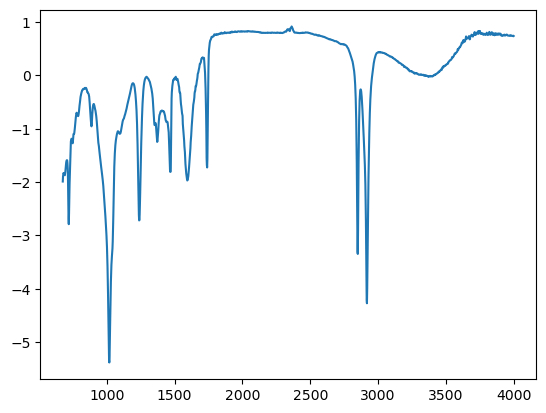

Prediction Set:  ['Polyamide', 'Polystyrene']


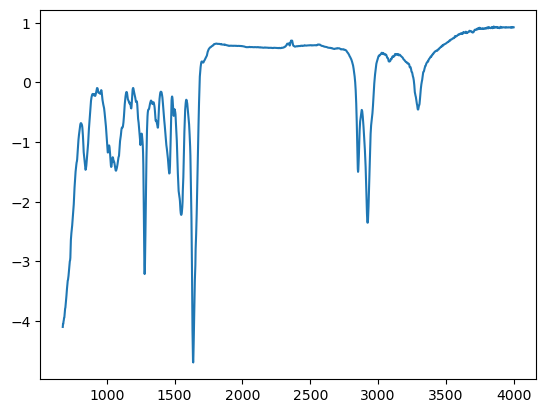

Prediction Set:  ['Polyethylene', 'Polyethylene Vinyl Acetate']


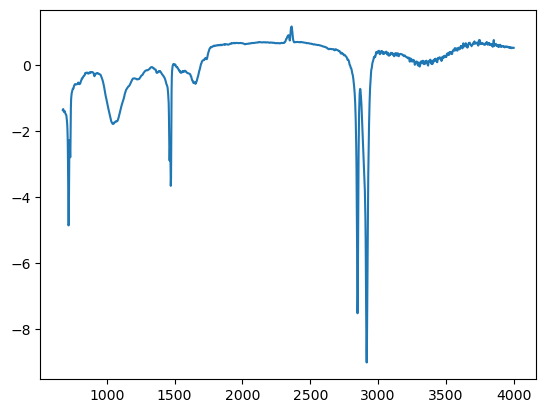

Prediction Set:  ['Polyethylene', 'Polyethylene Vinyl Acetate']


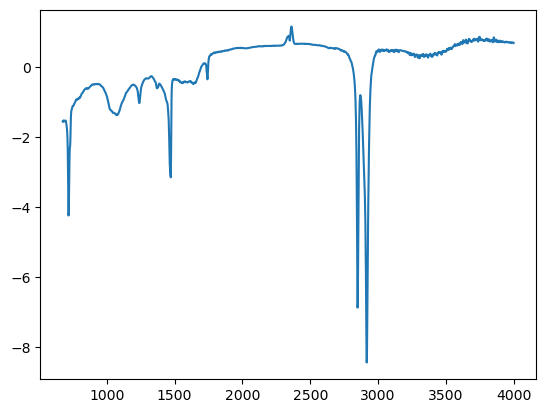

Prediction Set:  ['Polyethylene', 'Polyethylene Vinyl Acetate']


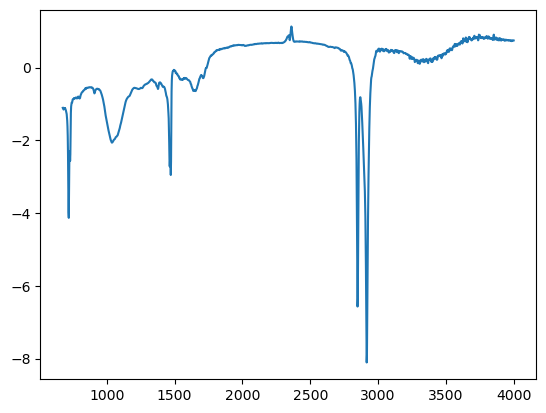

Prediction Set:  ['Polypropylene', 'Rubber']


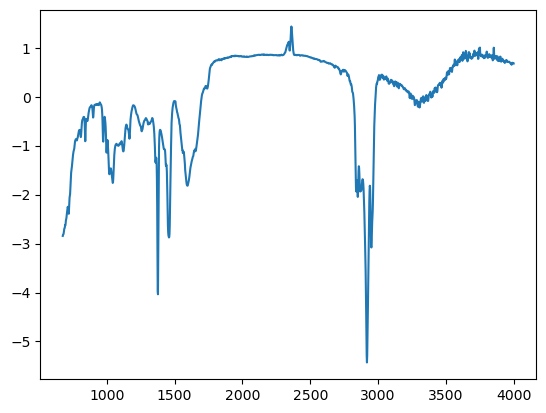

Prediction Set:  ['Cotton', 'Polyamide', 'Polyethylene Terephthalate', 'Polyethylene Vinyl Acetate', 'Polypropylene', 'Polystyrene', 'Polyurethane', 'Polyvinyl Chloride', 'Rubber']


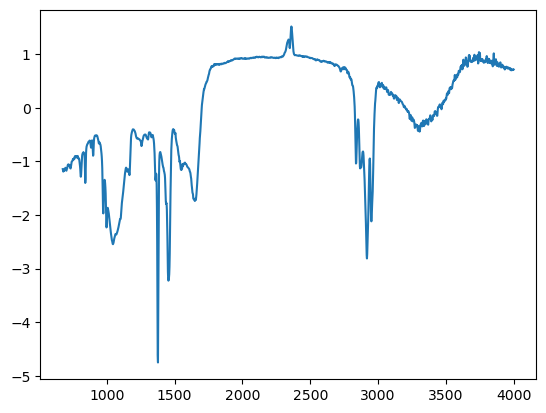

Prediction Set:  ['Acrylonitrile Butadiene Styrene', 'Cotton', 'Polystyrene', 'Polyurethane', 'Polyvinyl Chloride', 'Rubber']


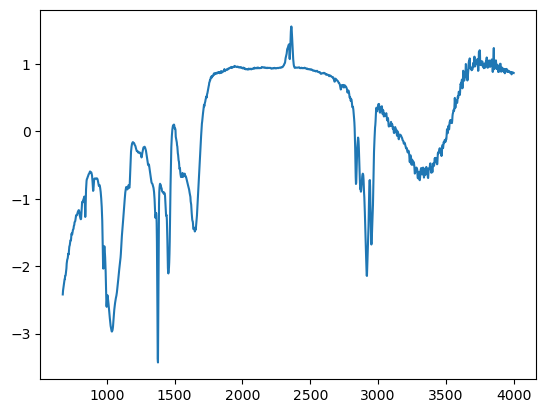

Prediction Set:  ['Cotton', 'Polyurethane', 'Polyvinyl Chloride', 'Rubber']


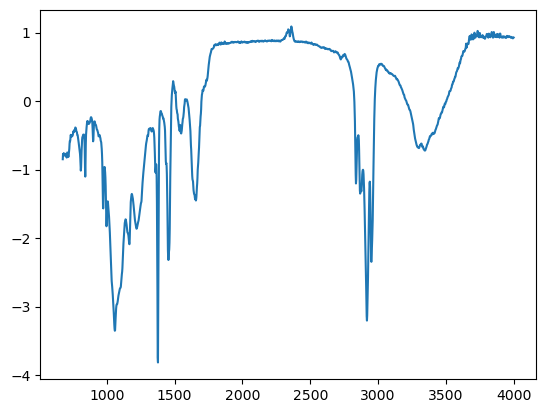

Prediction Set:  ['Polyethylene Terephthalate', 'Polyurethane', 'Polyvinyl Chloride']


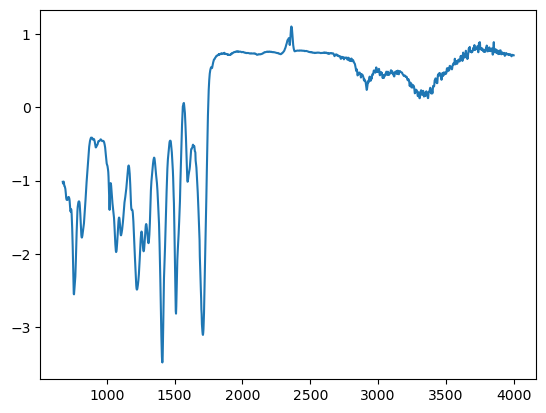

Prediction Set:  ['Acrylic', 'Polyethylene Terephthalate', 'Polyurethane', 'Polyvinyl Chloride']


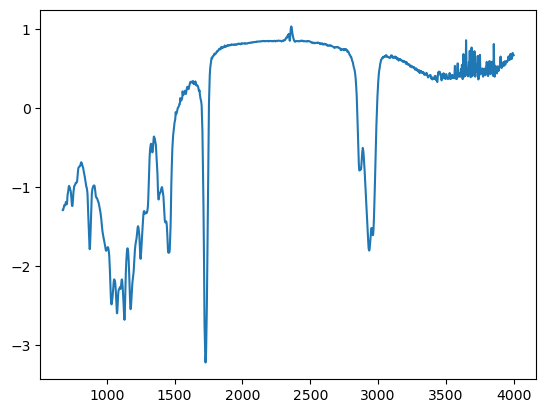

In [26]:
#i = mult_label[0]
for i in mult_label:
    print('Prediction Set: ', prediction_sets_n[i])
    plt.plot(wl_list, X_test[i])
    plt.show()